# Generate Synthetic Air traffic Data

In [ ]:
!pip install --target="/content/drive/MyDrive/network_traffic_pred/colab_packages" numpy
!pip install --target="/content/drive/MyDrive/network_traffic_pred/colab_packages" geopandas
!pip install --target="/content/drive/MyDrive/network_traffic_pred/colab_packages" cartopy
!pip install --target="/content/drive/MyDrive/network_traffic_pred/colab_packages" pandas
!pip install --target="/content/drive/MyDrive/network_traffic_pred/colab_packages" networkx
!pip install --target="/content/drive/MyDrive/network_traffic_pred/colab_packages" matplotlib


In [71]:
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('/content/drive/MyDrive/network_traffic_pred/colab_packages')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [72]:
import math

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy import crs as ccrs
from cartopy.io import shapereader

In [73]:
# Set up the total days for generating data
NUM_DEMAND_DAYS = 31
# Fix the random seed
np.random.seed(47)

## Fetch Airport Data

In [74]:
# Fetch a list of N airport codes (three letter IATA codes) and their lat, lon coordinates
def fetch_airports_data(N=100):
    # You can use a public CSV file with airport data
    path = 'https://raw.githubusercontent.com/davidmegginson/ourairports-data/refs/heads/main/airports.csv'

    airports = pd.read_csv(path)

    # Process `continent` column to replace NaN with string NA
    airports['continent'].fillna('NA', inplace=True)

    # filter out valid major airports in the world
    airports = airports[(airports['type'] == 'large_airport') & \
                        airports['iata_code'].notna() & \
                        airports['iso_country'].notna()]

    # Select only the first N airports and relevant columns
    selected_airports = airports[['iata_code', 'name', 'continent', 'iso_country', 'latitude_deg', 'longitude_deg']].head(N)
    return selected_airports

# Extract first 400 major airports
airports_df = fetch_airports_data(N=400)

airports_df.head()

<ipython-input-74-ceb619fc5230>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  airports['continent'].fillna('NA', inplace=True)


,iata_code,name,continent,iso_country,latitude_deg,longitude_deg
9620,HIR,Honiara International Airport,OC,SB,-9.428000,160.054993
11915,POM,Port Moresby Jacksons International Airport,OC,PG,-9.443380,147.220001
12654,KEF,Keflavik International Airport,EU,IS,63.985001,-22.605600
20474,YEG,Edmonton International Airport,NA,CA,53.309700,-113.580002
20531,YHZ,Halifax / Stanfield International Airport,NA,CA,44.880798,-63.508598


In [75]:
# Create a Networkx graph where nodes are the airports, and edges are demands between any two airports.
def create_airport_graph(airports_df):
    G = nx.Graph()

    # Add nodes
    for _, row in airports_df.iterrows():
        G.add_node(row['iata_code'], pos=(row['longitude_deg'], row['latitude_deg']))

    # Create edges between any two airports but not self loop
    np.random.seed(42)  # For reproducibility
    for i, source in enumerate(airports_df['iata_code']):
        for j, target in enumerate(airports_df['iata_code']):
            if i != j:  # Avoid self-loops and duplicate edges
                G.add_edge(source, target)
    return G

G = create_airport_graph(airports_df)

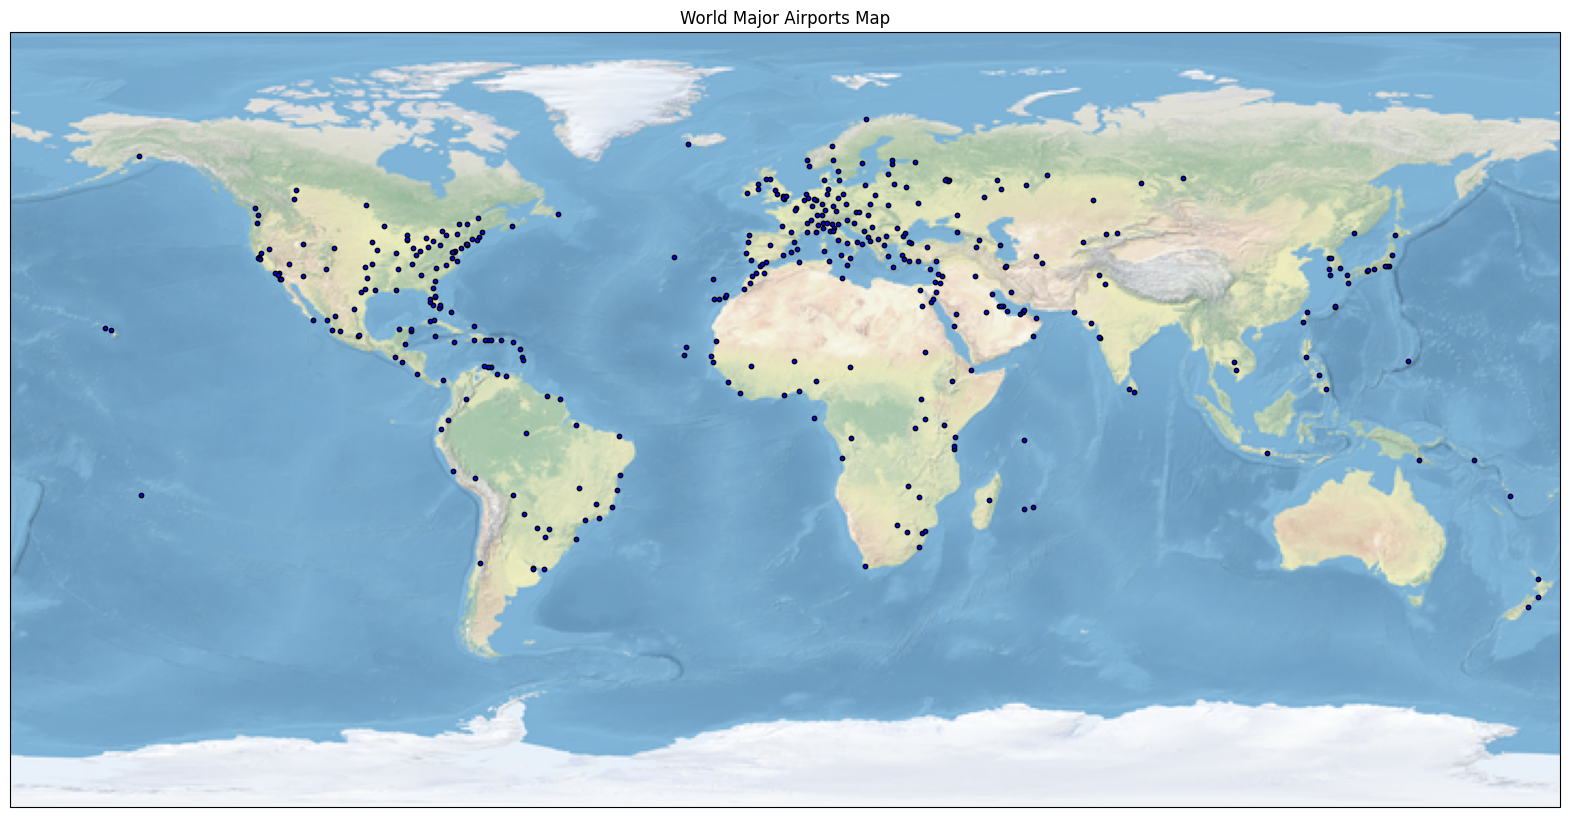

In [76]:
# Plot the airports only on a world map
def plot_graph(G, title, draw_edges=False):
    fig, ax = plt.subplots(figsize=(20, 14), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

    # Add the world background map
    ax.stock_img()

    # Get the node positions (longitude, latitude)
    pos = nx.get_node_attributes(G, 'pos')

    # Plot nodes (metros/airports)
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', ax=ax, edgecolors='k')

    # Plot edges (connections between metros)
    if draw_edges:
        edges = G.edges(data=True)
        for edge in edges:
            src, dst, data = edge
            coord_src = pos[src]
            coord_dst = pos[dst]
            ax.plot([coord_src[0], coord_dst[0]], [coord_src[1], coord_dst[1]],
                    color='m', linestyle='-', linewidth=1, alpha=0.075)

    # plt.title("Airports Network with Connections")
    plt.title(title)

    plt.show()

plot_graph(G, title="World Major Airports Map")

In [77]:
# create fully connected airport pairs
airports = airports_df.iata_code.to_numpy().tolist()
num_aps = len(airports)
src_aps = []
dst_aps = []
for i, airport in enumerate(airports):
    src_aps += [airport] * (num_aps - 1)
    dst_ap = airports[:i] + airports[i+1:]
    dst_aps += dst_ap
airport_pair_full_df = pd.DataFrame({'src': src_aps, 'dst': dst_aps})

# add source and destination countries
airport_pair_full_df = pd.merge(airport_pair_full_df, airports_df[['iata_code', 'iso_country']], how='left',
                                left_on='src', right_on='iata_code').drop(columns=["iata_code"])
airport_pair_full_df = pd.merge(airport_pair_full_df, airports_df[['iata_code', 'iso_country']], how='left',
                                left_on='dst', right_on='iata_code').drop(columns=["iata_code"])
airport_pair_full_df.rename(columns={'iso_country_x': 'iso_country_src', 'iso_country_y': 'iso_country_dst'},
                            inplace=True)

# Get countries DF with number of airports in each country
country_df = airports_df.groupby(by=['iso_country'])['name'].count().sort_values(ascending=False)
country_df = country_df.reset_index()
country_df.rename(columns={'name':'airport_cnt'}, inplace=True)


## Create Synthetic Airlines and flights


In [78]:
# Set the proportion ratio of the number of airlines to the number of aiports
airline_to_country_ratio = 0.15
country_df['airline'] = country_df.apply(lambda x: [x.iso_country + '_AL' + str(i+1) \
                                                    for i in range(math.ceil(x.airport_cnt * airline_to_country_ratio))], axis=1)
airlines_by_country = country_df.airline.tolist()
airlines = []
for al_country in airlines_by_country:
    airlines += al_country

print(f'There are totally {len(airlines)} airlines generated.')
country_df.head()

There are totally 170 airlines generated.


,iso_country,airport_cnt,airline
0,US,71,"[US_AL1, US_AL2, US_AL3, US_AL4, US_AL5, US_AL..."
1,IT,16,"[IT_AL1, IT_AL2, IT_AL3]"
2,RU,15,"[RU_AL1, RU_AL2, RU_AL3]"
3,JP,12,"[JP_AL1, JP_AL2]"
4,MX,12,"[MX_AL1, MX_AL2]"


In [79]:
def generate_flights(al_country, hub, is_intl, airport_pair_full_df, num_flights):
    """ Generate flights for an airline.

    Use a simple design:
    1. if domestic only, half flights will be one-hop and another half will be two-hop.
    2. if international, half flights will be one-hop domestic, quarter flights will be two-hop domestics, and the
       rest quarter will be international.
    Return
    -------
    flight_df: DataFrame
        A dataframe with 4 columns, fligt_num, src, dst, capacity
    """
    domestic_pair = airport_pair_full_df[(airport_pair_full_df.iso_country_src == al_country) &
                                         (airport_pair_full_df.iso_country_dst == al_country)]
    domestic_one_hop = domestic_pair[domestic_pair.src == hub]
    international_pair = airport_pair_full_df[(airport_pair_full_df.src == hub) &
                                              (airport_pair_full_df.iso_country_dst != al_country)]

    # Sepcial case, only one aiport in a country. So only international flights
    if domestic_pair.shape[0] == 0:
        flights = international_pair.sample(num_flights)
        flights['flight_num'] = np.arange(1, flights.shape[0]+1)
        flights['capacity'] = flights.apply(generate_capacity, axis=1)

        return flights

    # one-hop domestic flights
    half_num_flights = math.ceil(num_flights * 0.5)
    one_hop_flights = domestic_one_hop.sample(n=half_num_flights, replace=True)

    # international flights
    another_half_num_flights = num_flights - half_num_flights
    third_quarter_num_flights = math.ceil(another_half_num_flights * 0.5)

    intl_flights = pd.DataFrame({'src': [], 'dst': [], 'iso_country_src': [], 'iso_country_dst': []})

    if is_intl:
        intl_flights = international_pair.sample(third_quarter_num_flights)
        rest_num_flights = another_half_num_flights - third_quarter_num_flights
        two_hop_flights = pd.merge(one_hop_flights, domestic_pair,
                                   how='inner', left_on='dst',
                                   right_on='src').sample(rest_num_flights, replace=True)
    else:
        two_hop_flights = pd.merge(one_hop_flights, domestic_pair,
                                   how='inner', left_on='dst',
                                   right_on='src').sample(another_half_num_flights, replace=True)

    two_hop_flights = two_hop_flights[['src_y', 'dst_y', 'iso_country_src_y', 'iso_country_dst_y']]
    two_hop_flights = two_hop_flights.rename(columns={'src_y':'src', 'dst_y': 'dst',
                                                      'iso_country_src_y': 'iso_country_src',
                                                      'iso_country_dst_y': 'iso_country_dst'})

    flights = pd.concat([one_hop_flights, two_hop_flights, intl_flights])

    # remove duplicate flights. All flights are round trips, so should no hub in dst column
    flights = flights[flights.dst != hub]

    flights['flight_num'] = np.arange(1, flights.shape[0]+1)

    flights['capacity'] = flights.apply(generate_capacity, axis=1)

    return flights


def generate_num_flight_per_airline(num_airports, flight_per_day=2):
    """
    Use the flight per day for one airline to compute the number flights for an airline.
    Also depends on the number of airports in a country.
    """
    power_ratio = 0
    if num_airports < 2**0:
        power_ratio = 0
    elif num_airports >= 2**0 and num_airports < 2**1:
        power_ratio = 1
    elif num_airports >= 2**1 and num_airports < 2**2:
        power_ratio = 1
    elif num_airports >= 2**2 and num_airports < 2**3:
        power_ratio = 2
    elif num_airports >= 2**3 and num_airports < 2**4:
        power_ratio = 2
    elif num_airports >= 2**4 and num_airports < 2**6:
        power_ratio = 3
    elif num_airports >= 2**5 and num_airports < 2**6:
        power_ratio = 3
    else:
        power_ratio = 4

    portional_flight_per_day = flight_per_day * power_ratio

    num_flights = portional_flight_per_day * num_airports
    return num_flights

def generate_capacity(row):
    domestic_capacities = [0.125, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    intl_capacities = [0.125, 0.5, 1]

    if row.iso_country_src == row.iso_country_dst:
        capacity = np.random.choice(domestic_capacities, 1)[0]
    else:
        capacity = np.random.choice(intl_capacities, 1)[0]

    return capacity


all_flight_list = []

for al in airlines:
    al_country = al[:2]

    country_aps = airports_df[airports_df.iso_country == al_country].iata_code.to_numpy()
    ap_cnt = country_aps.shape[0]
    is_intl = np.random.choice([0, 1], p=[0.5, 0.5]) if ap_cnt > 1 else 1

    al_hub = np.random.choice(country_aps, 1)[0]

    num_flights = generate_num_flight_per_airline(ap_cnt)

    al_flights = generate_flights(al_country, al_hub, is_intl, airport_pair_full_df, num_flights)

    al_flights['flight_num'] = al + '_' + al_flights['flight_num'].astype(str)

    all_flight_list.append(al_flights)

all_flights = pd.concat(all_flight_list)

# to build bi-directional flights, capacity should be divided by 2
all_flights['capacity'] = all_flights['capacity'] / 2

all_flights_rev = all_flights[['dst', 'src', 'iso_country_dst', 'iso_country_src', 'flight_num', 'capacity']]
all_flights_rev.rename(columns={'dst':'src', 'src': 'dst',
                                'iso_country_dst': 'iso_country_src', 'iso_country_src': 'iso_country_dst'}, inplace=True)
all_flights_rev['flight_num'] = all_flights_rev['flight_num'] + '_rev'
all_flights_full = pd.concat([all_flights, all_flights_rev])
print(f'Total capacity in the world: {all_flights_full.capacity.sum()} for {all_flights_full.shape[0]} flights')

Total capacity in the world: 14206.5 for 15622 flights


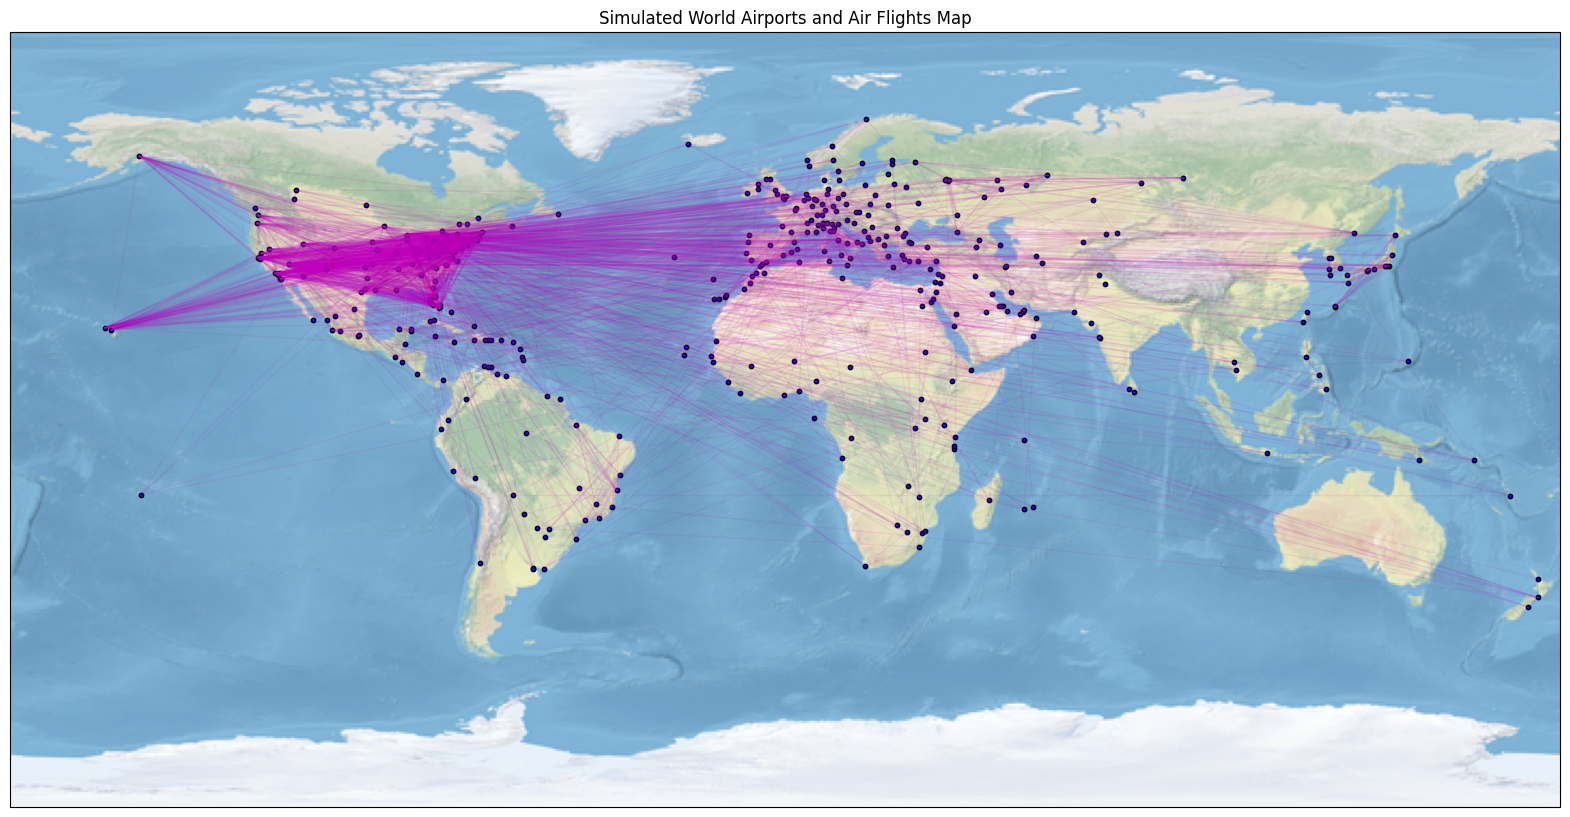

In [80]:
flight_G = nx.Graph()

nids = []
# Add nodes from airports_df
for _, row in airports_df.iterrows():
    flight_G.add_node(row['iata_code'], pos=(row['longitude_deg'], row['latitude_deg']))

# Create edges based on generated flights
for _, row in all_flights_full.iterrows():
    flight_G.add_edge(row['src'], row['dst'], capacity=row['capacity'])

plot_graph(flight_G, title="Simulated World Airports and Air Flights Map", draw_edges=True)

## Generate demand

In [81]:
def generate_demand_timeseries(top, scale=1, n_days=365):
    # Create a combination of sinusoids to simulate daily demand with weekly pattern
    assert top >= scale
    days = np.arange(n_days)
    weekly_demand = np.clip(scale * (np.sin(2 * np.pi * days / 7) + (top - scale)) + np.random.normal(-scale, scale, n_days),
                            a_min=0, a_max=top)
    # remove very small demands to avoid nearly 0 paylod
    weekly_demand = np.round(weekly_demand, 2)
    return weekly_demand

def get_ratio(num_airports, scale=1):
    power_ratio = 0
    if num_airports < 2**0:
        power_ratio = 0
    elif num_airports >= 2**0 and num_airports < 2**1:
        power_ratio = 1
    elif num_airports >= 2**1 and num_airports < 2**2:
        power_ratio = 1
    elif num_airports >= 2**2 and num_airports < 2**3:
        power_ratio = 2
    elif num_airports >= 2**3 and num_airports < 2**4:
        power_ratio = 2
    elif num_airports >= 2**4 and num_airports < 2**6:
        power_ratio = 3
    elif num_airports >= 2**5 and num_airports < 2**6:
        power_ratio = 3
    else:
        power_ratio = 4

    return math.ceil(power_ratio * scale)


def generate_pair_demands(src_cn, dst_cn, n_days, num_aps_dict):
    """ Generate demands for all airport pairs with given number of days.

    The demands should follow the 3 rules:
    1. demands are propotional to the number of airports in a country;
    2. demands for domestic pairs is 4 times of international pairs;
    3. the number of airports will determine the arguments of generate_demand_timeseries(), top and scale.
    """
    # src_cn = row['iso_country_src']
    # dst_cn = row['iso_country_dst']
    num_aps = num_aps_dict[src_cn]
    if src_cn == dst_cn:    # a domestic pair
        power_ratio = get_ratio(num_aps, scale=0.5)
    else:                   # an international pair
        power_ratio = get_ratio(num_aps, scale=0.125)

    demands = generate_demand_timeseries(top=power_ratio, scale=1, n_days=n_days)

    return demands


num_aps_dict = {}
for _, row in country_df.iterrows():
    num_aps_dict[row['iso_country']] = row['airport_cnt']

airport_pair_full_df['demands'] = airport_pair_full_df.apply(lambda row: generate_pair_demands(row['iso_country_src'],
                                                                                               row['iso_country_dst'],
                                                                                               NUM_DEMAND_DAYS,
                                                                                               num_aps_dict),
                                                             axis=1)

## Demand Fulfillment

In [82]:
class Traffic():
    """
    """
    def __init__(self,
                 header,
                 payload):
        assert len(header) > 0, 'The header must contains at least one airport, ' + \
                                f'but got {header}.'
        self._header = header
        assert round(payload, 4) > 0, 'Payload should be a value greather than 0. ' + \
                                     f'but got to {header} with {payload}.'
        self._payload = round(payload, 4)

    def next_stop(self):
        if len(self._header) > 1:
            next_stop = self._header.pop(0)
        elif len(self._header) == 1:
            next_stop = self._header[0]
        else:
            next_stop = None
        return next_stop

    def is_final(self, airport=None):
        if airport is not None:
            return len(self._header) == 1 and self._header[0] == airport
        else:
            return len(self._header) == 1

    def get_header(self):
        """ Give a copy of the header to avoid mutation by others.
        """
        cp_header = [ap for ap in self._header]
        return cp_header

    def get_payload(self):
        return self._payload

    def set_payload(self, payload):
        assert payload > 0, 'Payload should be a value greather than 0.'
        self._payload = payload

    def to_string(self):
        return '(' + '->'.join(self._header) + ': ' + str(self._payload) + ')'


class AirportRouter():
    """ A router that simulate how to relay traffics

    Parameters
    ----------
    name: str
        Name of this airport.
    routing_tables: dict of list of lists
        Pre-computed shortest paths to other airports from this airport in the format of
        {dst: [[airport1, airport2, ...], [...]], dst: [[]]}
    flights_tables: dict of list of tuples
        Available connected airports with flights in the format of
        {dst: [(flight1, cap), (flight2, cap), ...], ...}
    """
    def __init__(self,
                 name,
                 routing_table,
                 flights_table):
        self.name = name
        self.routing_table = routing_table
        self.flights_table = flights_table
        self.stored_traffics = {}

    def to_string(self):
        """ Output stored traffics for easy debug.
        """
        outputs = ''
        for next_stop, next_stop_queue in self.stored_traffics.items():
            queue_outputs = [traffic.to_string() for traffic in next_stop_queue]
            next_stop_outputs = next_stop + ': ' + '\t'.join(queue_outputs)
            outputs += next_stop_outputs + '\n'
        return outputs

    def add_demand(self, dst, demand):
        """ Accept local demand to the destination airport.

        For the demand, extract the shortest paths from this airport to the dst airport.
        If only one path, create one traffic, whose header is the path, and payload is the
        demand number.
        If there are multiple paths, create multiple traffics, evenly distribute demands.
        """
        # The demand is too small, ignored...
        if demand < 0.001:
            return
        else:
            pre_demand = round(demand, 4)

        shortest_paths = self.routing_table[dst]

        ave_demand = round(demand/len(shortest_paths), 4)

        # if the demand is too small to be split, only use the first shortest path to deliver.
        if ave_demand < 0.001:
            new_shortest_path = [airport for airport in shortest_paths[0]]
            traffic = Traffic(new_shortest_path, demand)

            # route this traffic in queue
            self._route_traffic(traffic)
        else:
            for shortest_path in shortest_paths:
                # copy the shortest path to avoid change the original
                new_shortest_path = [airport for airport in shortest_path]
                traffic = Traffic(new_shortest_path, ave_demand)

                # route this traffic in queue
                self._route_traffic(traffic)

    def add_traffics(self, traffics):
        """ Add incoming flight traffics.

        A traffic has a header and a payload.
        - The header contains a list of airports, indicating the next stops to send.
        - The payload is a number.

        In an incoming traffic, the first airport in the header should be same as this airport.
        When add a traffic, first get the first airport as the next stop from the header, and
        then check the next stop to relay this traffic. If no next stop, i.e., the traffic has
        reach its final destination, delete this traffic and no further action. If there is the
        next stop, add this traffic to the stored traffics under the same next stop airport.
        """
        for traffic in traffics:

            if traffic.is_final(self.name):
                del traffic
                continue
                # Comment out print claude to save spaces
                # print(f'The traffic {traffic.to_string()} arrives its final destination.')
            else:
                self._route_traffic(traffic)

    def _route_traffic(self, traffic):
        """ Take a traffic and route it to the correct queue for dispatch.
        """
        next_stop = traffic.next_stop()
        assert next_stop is not None, 'This is an invalid traffic or the traffic has reach its ' + \
                                      'final destionation'
        if self.stored_traffics.get(next_stop, None) is None:
            self.stored_traffics[next_stop] = [traffic]
        else:
            next_stop_queue = self.stored_traffics.get(next_stop)
            next_stop_queue.append(traffic)

    def dispatch_traffics(self):
        """ dispatch the stored traffics based on the airport's next stops.

        Iterate the stored_traffics. For each traffic, extract its next airport, and then check the
        flights_table to find out available flights. If there are available flights, evenly send out
        traffics to the next stops.
        """
        out_traffics = {}
        fulfilled_next_stops = []

        for next_stop, next_stop_queue in self.stored_traffics.items():

            new_next_stop_queue = []

            # extract available flights by making copeis, so that later operation will not modify the
            # predefined flight table.
            flights = [(flight, capacity) for (flight, capacity) in self.flights_table[next_stop]]

            while len(next_stop_queue) > 0:
                traffic = next_stop_queue.pop(0)
                payload = traffic.get_payload()
                while len(flights) > 0:
                    flight, capacity = flights.pop(0)
                    if payload > capacity:    # this flight is not enough
                        new_payload = round(capacity, 4)
                        if new_payload > 0.001:
                            out_traffic = Traffic(traffic.get_header(), new_payload)
                            new_next_stop_queue.append(out_traffic)
                        payload = round((payload - capacity), 4)
                        if payload < 0.001:
                            break
                    elif payload == capacity:
                        new_payload = round(payload, 4)
                        if new_payload > 0.001:
                            out_traffic = Traffic(traffic.get_header(), new_payload)
                            new_next_stop_queue.append(out_traffic)
                        else:
                            payload = 0
                        break
                    else:                      # this flight has redundent capacity
                        new_payload = round(payload, 4)
                        if new_payload > 0.001:
                            out_traffic = Traffic(traffic.get_header(), new_payload)
                            new_next_stop_queue.append(out_traffic)
                        rest_capacity = round((capacity - new_payload), 4)
                        if rest_capacity > 0.001:
                            flights = [(flight, rest_capacity)] + flights
                        else:
                            payload = 0
                        break
                # All flights can not deliver stored queue, and the rest payload is big enough
                if payload > 0.:
                    traffic.set_payload(payload)
                    next_stop_queue.insert(0, traffic)    # use the original pointer of this list
                    break
            # add new queue to out traffics
            if new_next_stop_queue:
                out_traffics[next_stop] = new_next_stop_queue
            # check if the queue is fulfilled
            if not next_stop_queue:
                fulfilled_next_stops.append(next_stop)

        # clean up fufilled next stops
        for next_stop in fulfilled_next_stops:
            del self.stored_traffics[next_stop]

        return out_traffics

    def current_inventory_amount(self):
        """ The current inventory total amount.
        """
        inventory_amount = 0
        for _, next_stop_queue in self.stored_traffics.items():
            for traffic in next_stop_queue:
                inventory_amount += traffic.get_payload()

        return inventory_amount

In [83]:
# Create routing dict {"src": {"dest": [shortest pahts]}
all_routing_table = {}

for src, dst_paths in dict(nx.all_pairs_all_shortest_paths(flight_G)).items():
    routing_table = {}
    for dst, paths in dst_paths.items():
        if src == dst:
            continue
        # remove the src from all path
        new_paths = [path[1:] for path in paths]
        routing_table[dst] = new_paths

    all_routing_table[src] = routing_table

total_num_aps = len(all_routing_table)
# sanity check to make sure all airports are connected to each other
for src, paths in all_routing_table.items():
    num_dsts = len(paths)
    if num_dsts != total_num_aps - 1:
        print(f'Source airport {src} can not reach to all airports, but {num_dsts}...')

# Create flights dict {"src": {"dest": [flights]}
all_flights_full['flights'] = list(zip(all_flights_full.flight_num, all_flights_full.capacity))
pair_flights = all_flights_full.groupby(by=['src', 'dst'])['flights'].apply(list).reset_index(name='flights')
airport_flights = pair_flights.groupby(by=['src']).agg(list)
airport_flights.reset_index(inplace=True)
all_flights_table = {}
for _, row in airport_flights.iterrows():
    src = row['src']
    dst_list = row['dst']
    flights_list = row['flights']
    # sanity check
    if len(dst_list) != len(flights_list):
        print(f'Invalid row: {row}')
    dst_flights = {}
    for dst, flights in zip(dst_list, flights_list):
        dst_flights[dst] = flights

    all_flights_table[src] = dst_flights

assert len(all_routing_table) == len(all_flights_table)

# expend the demand list in airport_pair_full_df to columns
demands_df = pd.DataFrame(airport_pair_full_df.demands.to_list(), columns=['demand_d'+str(i) for i in range(NUM_DEMAND_DAYS)])
demands_df = pd.concat([airport_pair_full_df[['src', 'dst', 'iso_country_src', 'iso_country_dst']], demands_df], axis=1)

In [84]:
def initialize_airports(all_routing_table, all_flights_table):
    airport_list = {}

    for src, routing_table in all_routing_table.items():
        airport_router = AirportRouter(src, routing_table, all_flights_table[src])
        airport_list[src] = airport_router
    return airport_list

def add_current_demands(airport_list, current_demands):
    airports = []
    inventory_amount_list = []
    for _, row in current_demands.iterrows():
        src = row['src']
        airport_router = airport_list[src]

        demand_list = row['current_demand']
        for dst, demand in demand_list:
            airport_router.add_demand(dst, demand)

        airports.append(src)
        inventory_amount_list.append(airport_router.current_inventory_amount())

    current_airport_inventory_df = pd.DataFrame({
        'iata_code': airports,
        'inventory_amount': inventory_amount_list
    })

    return current_airport_inventory_df

def dispatch_demands(airport_list):
    """ Dispatch demands in all airports

    Return: a dict of list of traffics as inputs of adding traffics to all airports.
    """
    dst_ap_traffics = {}
    ap2ap_traffics = {}
    for src_ap, airport_router in airport_list.items():
        output_traffics = airport_router.dispatch_traffics()
        for next_stop_ap, traffics in output_traffics.items():
            # extract destination airport based traffics
            if dst_ap_traffics.get(next_stop_ap, None) is None:
                dst_ap_traffics[next_stop_ap] = traffics
            else:
                existing_traffics = dst_ap_traffics[next_stop_ap]
                dst_ap_traffics[next_stop_ap] = existing_traffics + traffics

            # extract pair-wised traffics
            if ap2ap_traffics.get((src_ap, next_stop_ap), None) is None:
                ap2ap_traffics[(src_ap, next_stop_ap)] = traffics
            else:
                existing_traffics = ap2ap_traffics[(src_ap, next_stop_ap)]
                ap2ap_traffics[(src_ap, next_stop_ap)] = existing_traffics + traffics

    return dst_ap_traffics, ap2ap_traffics

# intialize all airport routers
airports = initialize_airports(all_routing_table, all_flights_table)
print(f'Total have {len(airports)} airports.')
inventory_list = []
ap2ap_traffics_df_list = []

for ts_day in range(NUM_DEMAND_DAYS):
    # extract the current day demands
    demand_current_ts = 'demand_d' + str(ts_day)
    # print(f'\n================ Process and Add Day {ts_day} Demands and Dispatch ==================')
    demands_df['current_demand'] = list(zip(demands_df.dst, demands_df[demand_current_ts]))
    current_demands = demands_df.groupby(by=['src'])['current_demand'].apply(list).reset_index(name='current_demand')

    # add current demands to all airports before dispatching traffics
    current_inventory_df = add_current_demands(airports, current_demands)
    current_inventory_df.rename(columns={'inventory_amount': 'inventory_amount_d'+str(ts_day)}, inplace=True)
    inventory_list.append(current_inventory_df)

    # dispatch demands to world wide airports
    dst_ap_traffics, ap2ap_traffics = dispatch_demands(airports)

    # collecting ap2ap traffic volume as edge ts features
    src_list = []
    dst_list = []
    traffic_payload_list = []
    for (src, dst), traffics in ap2ap_traffics.items():
        src_list.append(src)
        dst_list.append(dst)
        total_payload = 0
        for traffic in traffics:
            total_payload += traffic.get_payload()
        traffic_payload_list.append(total_payload)
    ap2ap_traffics_df = pd.DataFrame({
        'src': src_list,
        'dst': dst_list,
        'traffic_payload_d'+str(ts_day): traffic_payload_list
    })
    ap2ap_traffics_df_list.append(ap2ap_traffics_df)

    # add traffics to all airports
    for dst_ap, traffics in dst_ap_traffics.items():
        dst_airport_router = airports[dst_ap]
        dst_airport_router.add_traffics(traffics)


Total have 400 airports.


## Save generate data

Airport node data

In [ ]:
airport_node_df = airports_df[['iata_code', 'latitude_deg', 'longitude_deg']]

for d, current_inventory_df in enumerate(inventory_list):
    current_inventory_df.rename(columns={'inventory_amount': 'inventory_amount_'+str(d)}, inplace=True)
    airport_node_df = pd.merge(airport_node_df, current_inventory_df, how='inner', on='iata_code')

print(airport_node_df.shape)

airport_node_df['inventory_amounts'] = airport_node_df[['inventory_amount_d'+str(d) for d in range(NUM_DEMAND_DAYS)]].values.tolist()
airport_node_df['inventory_amounts'] = airport_node_df['inventory_amounts'].apply(lambda x: [round(v, 4) for v in x])

airport_node_df[['iata_code', 'latitude_deg', 'longitude_deg', 'inventory_amounts']].to_parquet('/content/drive/MyDrive/network_traffic_pred/data/airport.parquet', index=False)

Edge data (demand)

In [97]:
# demand edge list
demand_edge_df = airport_pair_full_df[['dst', 'src', 'demands']]
#reverse the demand edge direction
#In message passing the edge data is only used in the dest note but we want demand to be passed to the src node
demand_edge_df.rename(columns={'dst': 'src_code', 'src': 'dst_code'}, inplace=True)
# save demand edge table to a local parquet file
demand_edge_df.to_parquet('/content/drive/MyDrive/network_traffic_pred/data/demand_edge.parquet', index=False)

<ipython-input-97-a81af4f082e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demand_edge_df.rename(columns={'dst': 'src_code', 'src': 'dst_code'}, inplace=True)


Edge data (traffic)

In [99]:
# traffic edge list
traffic_edge_df = pd.DataFrame(all_flights_full.groupby(by=['src', 'dst'])['capacity'].sum())
traffic_edge_df.reset_index(inplace=True)
for ap2ap_traffic_df in ap2ap_traffics_df_list:
    traffic_edge_df = pd.merge(traffic_edge_df, ap2ap_traffic_df, how='left', on=['src', 'dst'])
# replace nan to 0
traffic_edge_df.fillna(0, inplace=True)
traffic_edge_df.rename(columns={'src': 'src_code', 'dst': 'dst_code'}, inplace=True)
# merge multiple columns into one column of list
traffic_edge_df['traffics'] = traffic_edge_df[['traffic_payload_d'+str(d) for d in range(NUM_DEMAND_DAYS)]].values.tolist()
# save traffic edge table to a local parquet file
traffic_edge_df[['src_code', 'dst_code', 'capacity', 'traffics']].to_parquet('/content/drive/MyDrive/traffic_edge.parquet', index=False)

# Graph Construction

In [ ]:
!pip install graphstorm

# If using CPU instances
!pip install torch==2.1.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install dgl==1.1.3 -f https://data.dgl.ai/wheels-internal/repo.html

In [6]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/network_traffic_pred/data"
import sys
sys.path.append('/content/drive/MyDrive/network_traffic_pred/colab_packages')

Mounted at /content/drive/


In [7]:
import os
import json
import pandas as pd
import graphstorm

## Prepare config

Node

In [9]:
airport_path = data_path + '/airport.parquet'
nodes = []
airport = {
    "node_type": "airport",
    "format": {
        "name": "parquet"
    },
    "files": [
        airport_path
    ],
    "node_id_col": "iata_code",
    "features": [
        {
            "feature_col": "latitude_deg",
            "feature_name": "latitude",
            "transform": {"name": "max_min_norm",
                          "max_val": 90.,
                          "min_val": -90.}
        },
        {
            "feature_col": "longitude_deg",
            "feature_name": "longitude",
            "transform": {"name": "max_min_norm",
                          "max_val": 180.,
                          "min_val": -180.}
        },
        {
            "feature_col": "inventory_amounts",
            "feature_name": "inventory_amounts",
            "transform": {"name": "max_min_norm",
                          "max_val": 1000.,
                          "min_val": 0.}
        }
    ],
    "labels": [
        {
            "label_col": "inventory_amounts",
            "task_type": "regression",
            "split_pct": [
                0.8,
                0.1,
                0.1
            ]
        }
    ]
}

nodes.append(airport)

Edges

In [10]:
traffic_edge_path = data_path + '/traffic_edge.parquet'
demand_edge_path = data_path + '/demand_edge.parquet'

edges = []
ap_demand_ap = {
    "relation": [
        "airport",
        "demand",
        "airport"
    ],
    "format": {
        "name": "parquet"
    },
    "files": [
        demand_edge_path
    ],
    "source_id_col": "src_code",
    "dest_id_col": "dst_code",
    "features": [
        {
            "feature_col": "demands",
            "feature_name": "demands",
            "transform": {
                        "name": "max_min_norm",
                        "max_val": 10.0,
                        "min_val": 0.0
                    }
        }
    ]
}
ap_traffic_ap = {
    "relation": [
        "airport",
        "traffic",
        "airport"
    ],
    "format": {
        "name": "parquet"
    },
    "files": [
        traffic_edge_path
    ],
    "source_id_col": "src_code",
    "dest_id_col": "dst_code",
    "features": [
        {
            "feature_col": "capacity",
            "feature_name": "capacity",
            "transform": {
                        "name": "max_min_norm",
                        "max_val": 10.0,
                        "min_val": 0.0
                    }
        },
        {
            "feature_col": "traffics",
            "feature_name": "traffics",
            "transform": {
                        "name": "max_min_norm",
                        "max_val": 10.0,
                        "min_val": 0.0
                    }
        }
    ]
}
edges.append(ap_demand_ap)
edges.append(ap_traffic_ap)

In [11]:
air_traffic_json = {"version": "gconstruct-v0.1"}
air_traffic_json['nodes'] = nodes
air_traffic_json['edges'] = edges
# Save to a local file, named config.json
with open(os.path.join(data_path, "config.json"), "w") as f:
    json.dump(air_traffic_json, f, indent=4)

## Construct Graphstorm graph

In [12]:
!python3 -m graphstorm.gconstruct.construct_graph \
           --conf-file /content/drive/MyDrive/network_traffic_pred/data/config.json \
           --output-dir /content/drive/MyDrive/network_traffic_pred/data/gs_1p/ \
           --num-parts 1 \
           --graph-name air_traffic

INFO:root:The graph has 1 node types and 2 edge types.
INFO:root:Node type airport has 400 nodes
INFO:root:Edge type ('airport', 'demand', 'airport') has 159600 edges
INFO:root:Edge type ('airport', 'traffic', 'airport') has 6720 edges
INFO:root:Node type airport has features: ['latitude', 'longitude', 'inventory_amounts', 'train_mask', 'val_mask', 'test_mask'].
INFO:root:Train/val/test on airport with mask train_mask, val_mask, test_mask: 320, 40, 40
INFO:root:Note: Custom train, validate, test mask information for nodes are not collected.
INFO:root:Edge type ('airport', 'demand', 'airport') has features: ['demands'].
INFO:root:Edge type ('airport', 'traffic', 'airport') has features: ['capacity', 'traffics'].
The graph has 1 node types and balance among 3 types
Converting to homogeneous graph takes 0.006s, peak mem: 2.225 GB
Save partitions: 0.052 seconds, peak memory: 2.225 GB
There are 166320 edges in the graph and 0 edge cuts for 1 partitions.
INFO:root:Graph construction generate

In [13]:
df = pd.read_parquet("/content/drive/MyDrive/network_traffic_pred/data/gs_1p/raw_id_mappings/airport/part-00000.parquet")